### Resources:

* http://www.twilightlandscapes.com/IRAFtutorial/IRAFintro_06.html

In [1]:
import os
import glob 

# Delete some directories/files from previous runs.

os.system("rm -rf login.cl database pyraf uparm")
os.system("mkiraf")


import astropy.io.fits as fits
%pylab
%matplotlib inline

# Dark subtract and flat field the spectra
from os.path import expanduser
home = expanduser("~/")
data_dir=home+"/data_home/ATC2017/61inch/23june_Spectra/"
pixelsize = 0.020#mm/pix
dispersion9_34 = 120.22*pixelsize#(A/mm)*mm/pix
dispersion11_23 = 121.08*pixelsize
center11_23 = 6000 #angstrom
center9_34 = 5000


Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
ls ~/data_home/ATC2017/61inch/23june_Spectra/

23june_narrowslit-001domeflat.fit
23june_narrowslit-002domeflat.fit
23june_narrowslit-003domeflat.fit
23june_narrowslit-004domeflat.fit
23june_narrowslit-005domeflat.fit
23june_narrowslit-006domeflat.fit
23june_narrowslit-007domeflat.fit
23june_narrowslit-008domeflat.fit
23june_narrowslit-009domeflat.fit
23june_wideslit-001Arcturus.fit
23june_wideslit-001Comet.fit
23june_wideslit-002Arcturus.fit
23june_wideslit-002Arcturus.fit.flattened.fits
23june_wideslit-003Arcturus.fit
23june_wideslit-004Arcturus.fit
23june_wideslit-005Arcturus.fit
23june_wideslit-006Arcturus.fit
23june_wideslit-007Arcturus.fit
23june_wideslit-008Arcturus.fit
23june_wideslit-009Arcturus.fit
23june_wideslit-010domeflat.fit
23june_wideslit-011domeflat.fit
23june_wideslit-012domeflat.fit
23june_wideslit_093grating-001arc.fit
23june_wideslit_093grating-001Barnard.fit
23june_wideslit_093grating-001M57.fit
23june_wideslit_093grating-001ngc6826.fit
23june_wideslit_093grating-002arc.fit
23june_wideslit_093grating-002Barnar

In [89]:
# The name of the science file.
dataset="23june_wideslit_11grating-"
target="Vega"
filename = dataset+target+ '.fits'
extracted_filename =  dataset+target+'.ms.fits'
calibrated_filename =  dataset+target+'.calib.fits'
dispersion=dispersion11_23
crval=center11_23
text_file = open("filename.txt", "w")
text_file.write(filename)
text_file.close()

import pickle

# obj0, obj1, obj2 are created here...

# Saving the objects,

with open('filenames.pickle', 'w') as f:  # Python 3: open(..., 'wb')
    pickle.dump([dataset, target, filename,extracted_filename,
                 calibrated_filename,
                 crval,
                 dispersion], f)



In [4]:
datafiles=glob.glob(data_dir+dataset+"*"+target+'.fit')
median_data=np.median(np.array([fits.getdata(dfile) for dfile in datafiles]  ),axis=0)

In [5]:
darkfiles=glob.glob(data_dir+"23june_wideslit_11grating-*dark1.fit")
median_dark=np.median(np.array([fits.getdata(dfile) for dfile in darkfiles]  ),axis=0)

## Use astropy to do initial data reduction

/home/edouglas/miniconda2/envs/iraf27/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()
/home/edouglas/miniconda2/envs/iraf27/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log10
  # This is added back by InteractiveShellApp.init_path()


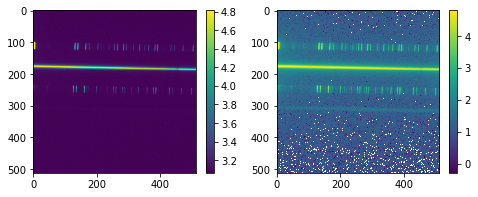

In [7]:
plt.figure(figsize=[8,3])
plt.subplot(121)
plt.imshow(np.log10(median_data))
plt.colorbar()


plt.subplot(122)
dark_sub_data = median_data - median_dark
#float_ is necessary to change the byte order, e.g.
#https://github.com/mperrin/poppy/issues/213#issuecomment-289166554
plt.imshow(np.log10(dark_sub_data))#,vmax=6e5,vmin=0 ) 
plt.colorbar()

fits.writeto(filename,data=dark_sub_data,clobber=True)

## Use pyraf to analyze the spectrum

In [115]:
%%bash
xterm python identify.py

xterm: Explicit shell already was /home/edouglas/miniconda2/envs/iraf27/bin/python
xterm: bad command line option "identify.py"

usage:  xterm [-/+132] [-C] [-Sccn] [-T string] [-/+ah] [-/+ai] [-/+aw]
    [-b number] [-/+bc] [-bcf milliseconds] [-bcn milliseconds] [-bd color]
    [-/+bdc] [-bg color] [-bw number] [-/+cb] [-cc classrange] [-/+cjk_width]
    [-class string] [-/+cm] [-/+cn] [-cr color] [-/+cu] [-/+dc]
    [-display displayname] [-e command args ...] [-fa pattern] [-fb fontname]
    [-/+fbb] [-/+fbx] [-fd pattern] [-fg color] [-fi fontname] [-fn fontname]
    [-fs size] [-/+fullscreen] [-fw fontname] [-fwb fontname] [-fx fontname]
    [%geom] [#geom] [-geometry geom] [-help] [-/+hm] [-/+hold] [-iconic]
    [-/+ie] [-/+im] [-into windowId] [-/+itc] [-/+j] [-/+k8] [-kt keyboardtype]
    [-/+l] [-/+lc] [-lcc path] [-leftbar] [-lf filename] [-/+ls] [-/+maximized]
    [-/+mb] [-mc milliseconds] [-/+mesg] [-/+mk_width] [-ms color] [-n string]
    [-name string] [-nb number] [-/+

In [8]:
# Now load IRAF
import pyraf.iraf as iraf

# Load the packages we might need.

iraf.noao(_doprint=0)
iraf.onedspec(_doprint=0)
iraf.twodspec(_doprint=0)
iraf.apextract(_doprint=0)
iraf.unlearn(iraf.apall)
iraf.unlearn(iraf.autoidentif)


Created directory /home/edouglas/astronomy-camp/python/CampSpec/pyraf for cache


In [9]:
# Delete previous results.

os.system("rm "+extracted_filename+" "+calibrated_filename)

# Make sure that the dispersion axis is in the header.

iraf.hedit(images=[filename], fields=["DISPAXIS"], value=["1"], add="Yes")

Commands for graphics windows:
1. `w` to enter zoom mode 
2. `e` in the bottom left and top right corner of the box you want zoom in to.
3. `w a` reset the zoom
4. `m` centroid and define center of the analysis aperture
5. `b` advance to setting the background
6. `s` select background
7. `f` fit background
8. `q` to advance to the next stage
9. `:or` increase order of polynomial fit


In [10]:
# Run the spectral extraction program.

iraf.apextract.setParam("dispaxis", "1")

iraf.apall(input=filename, find="No", recenter="No", resize="No",interactive="Yes")
filename

Edit apertures for 23june_wideslit_11grating-Vega?

     aperture = 1  beam = 1  center = 182.05  low = -5.00  upper = 5.00
     aperture = 1  beam = 1  center = 182.05  low = -5.00  upper = 5.00


Trace apertures for 23june_wideslit_11grating-Vega?Fit traced positions for 23june_wideslit_11grating-Vega interactively?Fit curve to aperture 1 of 23june_wideslit_11grating-Vega interactivelyWrite apertures for 23june_wideslit_11grating-Vega to databaseExtract aperture spectra for 23june_wideslit_11grating-Vega?Review extracted spectra from 23june_wideslit_11grating-Vega?Review extracted spectrum for aperture 1 from 23june_wideslit_11grating-Vega?

'23june_wideslit_11grating-Vega.fits'

In [27]:
pixelsize = 0.020#mm/pix
dispersion9_34 = 120.22*pixelsize#(A/mm)*mm/pix
dispersion11_23 = 121.08*pixelsize
center11_23 = 6000 #angstrom
center9_34 = 5000
dispersion11_23

2.4216

In [80]:

iraf.identify(filename[:-5], coordli=home+"/Downloads/HgNe(1).dat",
              section="line 105 125",)

      5.58  5.5808167 (     INDEF ):       5.58  5.5808167      INDEF 
Write feature data to the database (yes)? 

In [33]:
iraf.autoidentify(filename[:-5], coordli=home+"/Downloads/HgNe(1).dat",
              section="line 265 285",
                  interactive='yes',
                  crval=center11_23,
                  cdelt=dispersion11_23,
                  fwidth=5)



AUTOIDENTIFY: NOAO/IRAF V2.16 edouglas@astrocamp-lts1604 Mon 08:51:59 26-Jun-2017
  Spectrum                 # Found   Midpoint Dispersion        RMS
  23june_wideslit_11grating-Vega[*,265]         23      6020.       2.21       1.64
23june_wideslit_11grating-Vega[*,265]: Examine identifications interactively?     47.22    5561.41      5562. Ne
    491.40  6539.5058 (     INDEF ):     491.40  6539.5058      INDEF 
    498.68  6555.5388 (     INDEF ):     498.68  6555.5388      INDEF 
    466.38  6484.3344 (     INDEF ):     466.38  6484.3344      INDEF 
    378.20  6289.3508 (     INDEF ):     378.20  6289.3508      INDEF 
     91.15  5656.8086      5656. Ne
    106.96  5691.2881      5689. Ne
    119.09  5717.7785      5719. Ne
    132.10   5746.228      5748. Ne
    140.93  5765.5573      5764. Ne
    151.24  5788.1746      5790. Hg
    193.45  5880.9117      5881. Ne
    204.18  5904.5382      5902. Ne
    222.12  5944.0833      5944. 
    234.89  5972.2754      5975. Ne
    261.00

    378.20  6287.0605      INDEF 
    358.25  6242.3057 (     INDEF ):     358.25  6242.3057      INDEF 
    358.25  6242.3057      INDEF 
    358.25  6242.3057      INDEF 
    358.25  6242.3057      INDEF 
    358.25  6242.3057      INDEF 
Center not found: check cursor position    439.38  6425.8363 (     INDEF ):     439.38  6425.8363      INDEF 
    428.61  6401.5982      6402. Ne
    428.61  6401.5982      6402. Ne
    498.68   6553.481      INDEF 
    498.68   6553.481      INDEF 
    330.43  6181.5856 (     INDEF ):     330.43  6181.5856      INDEF 
    330.43  6176.2163      INDEF 
     47.22    5561.41      5562. Ne
     47.22    5561.41      5562. Ne
     47.22    5561.41      5562. Ne
     47.22    5561.41      5562. Ne
23june_wideslit_11grating-Vega[*,265]: Write results to database?

In [34]:
ls

23june_wideslit_11grating-Vega.calib.fits        database/
23june_wideslit_11grating-Vega.fits              logfile
23june_wideslit_11grating-Vega.ms.fits           login.cl
23june_wideslit_9.3grating-Vega.fits             pyraf/
23june_wideslit_9.3grating-Vega.ms.fits          reduce_spectroscopy.py
campspec.cl                                      splot.log
camp_spec_notebook-Copy1.ipynb                   untitled
camp_spec_notebook.ipynb                         Untitled.ipynb
comparing_galaxies_mars_bars_spectroscopy.ipynb  uparm/


In [82]:
# Tell the extracted spectrum what the wavelength solutions are.

iraf.hedit(images=[extracted_filename],
           fields=["REFSPEC1"], \
        value=[filename], add="Yes")

iraf.dispcor(input=extracted_filename,
             output=calibrated_filename)

# Plot the extracted spectrum?

23june_wideslit_11grating-Vega.ms.fits: Resampling using current coordinate system
23june_wideslit_11grating-Vega.calib.fits: ap = 1, w1 =       1., w2 =     512., dw =       1., nw = 512


In [83]:
iraf.splot(calibrated_filename)

Killing IRAF task `splot'


IrafError: Error running IRAF task splot
IRAF task terminated abnormally
ERROR (1113, "FXF: must specify which FITS extension (23june_wideslit_11grating-Vega.calib.fits)")


In [75]:
#when in doubt:
iraf.flpr()
iraf.flpr()
iraf.flpr()


In [69]:
fits.getdata(extracted_filename)

array([ 250586.765625 ,  260462.859375 ,  260127.890625 ,  261571.03125  ,
        261865.328125 ,  261620.578125 ,  262748.5625   ,  262855.34375  ,
        263527.1875   ,  262508.1875   ,  264197.90625  ,  264167.09375  ,
        263996.0625   ,  264919.75     ,  264076.40625  ,  264073.78125  ,
        263848.34375  ,  264822.875    ,  264133.09375  ,  263302.9375   ,
        263621.84375  ,  263320.125    ,  263289.       ,  263556.5      ,
        263142.3125   ,  263019.3125   ,  263441.4375   ,  262714.40625  ,
        262488.84375  ,  261385.046875 ,  260404.59375  ,  259945.875    ,
        259714.0625   ,  260689.1875   ,  260454.859375 ,  260186.265625 ,
        259282.484375 ,  259059.09375  ,  259418.765625 ,  258921.953125 ,
        257648.203125 ,  258493.90625  ,  258173.609375 ,  257680.515625 ,
        256777.546875 ,  255976.234375 ,  255502.765625 ,  255935.765625 ,
        255441.140625 ,  254828.75     ,  254621.5625   ,  254232.21875  ,
        253102.5625   ,  

(0, 700000.0)

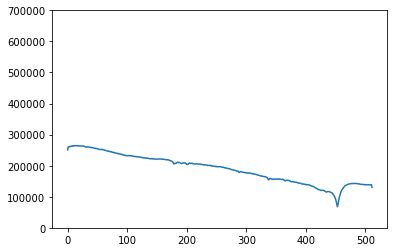

In [70]:
plt.plot(fits.getdata(extracted_filename))
plt.ylim([0,7e5])


(0, 700000.0)

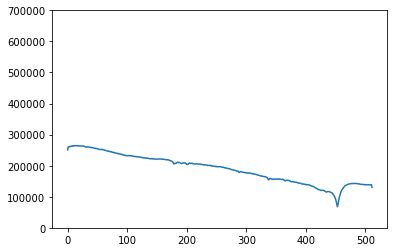

In [71]:
plt.plot(fits.getdata(calibrated_filename))
plt.ylim([0,7e5])

In [ ]:
A0V=fits.getdata(home+"/Downloads/pickles_uk_9.fits")
plot(A0V["WAVELENGTH"],A0V["FLUX"])

In [ ]:
from scipy.interpolate import interp1d
A0V_interpolator = interp1d(A0V["WAVELENGTH"],A0V["FLUX"])


In [103]:
cal=fits.open(extracted_filename)
calibrated_filename

'23june_wideslit_11grating-Vega.calib.fits'

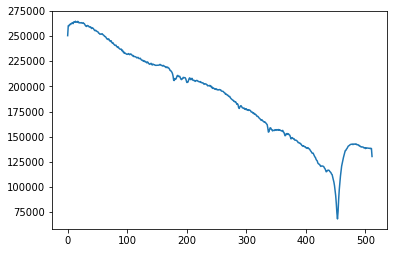

In [106]:
plt.plot(cal[0].data)

In [111]:
cal[0].header

SIMPLE  =                    T / Fits standard                                  
BITPIX  =                  -32 / Bits per pixel                                 
NAXIS   =                    1 / Number of axes                                 
NAXIS1  =                  512 / Axis length                                    
EXTEND  =                    T / File may contain extensions                    
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        
DATE    = '2017-06-26T08:40:07' / Date FITS file was generated                  
IRAF-TLM= '2017-06-26T08:40:07' / Time of last modification                     
BANDID1 = 'spectrum - background none, weights none, clean no'                  
APNUM1  = '1 1 177.05 187.05'                                                   
WCSDIM  =                    1                                                  
CTYPE1  = 'PIXEL   '                                                            
CRVAL1  =                   